In [402]:
# Import library yang kalian butuhkan
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import sklearn
from tqdm import tqdm

Pada Script diatas terdapat 8 line yang berisi 8 library yang dibutuhkan pada program ini, yaitu : 
- Library cv2 (OpenCV): adalah library yang digunakan untuk membaca, menulis, dan memanipulasi gambar dan video.
- Library numpy (np): adalah library yang digunakan untuk komputasi numerik dan manipulasi array multidimensi.
- Library matplotlib.pyplot (plt): adalah library yang digunakan untuk visualisasi data dalam bentuk grafik atau membuat grafik, histogram, scatter plot, dll.
- Library pandas (pd): library yang digunakan untuk manipulasi dan analisis data.
- Library math: adalah modul standar Python yang digunakan untuk menyediakan fungsi matematika dasar.
- Library os: adalah modul standar Python yang digunakan untuk menyediakan fungsi untuk berinteraksi dengan sistem operasi.
- Library sklearn (scikit-learn): adalah library yang digunakan untuk machine learning di Python.
- Library tqdm: adalah library yang digunakan untuk membuat progress bar yang interaktif dan mudah digunakan.

## Data Loading

In [403]:
df = pd.read_csv('validation.csv')
df.head(2)

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_90,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135
0,1768.320952,1930.804999,1137.489905,1365.584606,23.408952,26.309066,17.052571,19.286253,0.35865,0.291555,...,0.677119,0.604250,0.063717,7.732198,0.050296,8.081334,0.088581,7.687207,0.070051,7.888678
1,1812.106476,962.718707,1484.389905,2024.235469,21.899238,13.042055,17.873333,24.230708,0.55361,0.616566,...,0.535699,0.373513,0.273481,5.519998,0.323768,5.276858,0.315946,5.237368,0.259917,5.575754


In [404]:
def display(gambar, titel,rows,columns):
    fig = plt.figure(figsize=(3*columns, rows*2)) 
    for i in range(rows*columns):
        fig.add_subplot(rows,columns, i+1) 
        plt.imshow(cv.cvtColor(gambar[i], cv.COLOR_BGR2RGB))
        plt.axis('off') 
        plt.title(titel[i])

finger_1
finger_2
finger_3
finger_4
finger_5


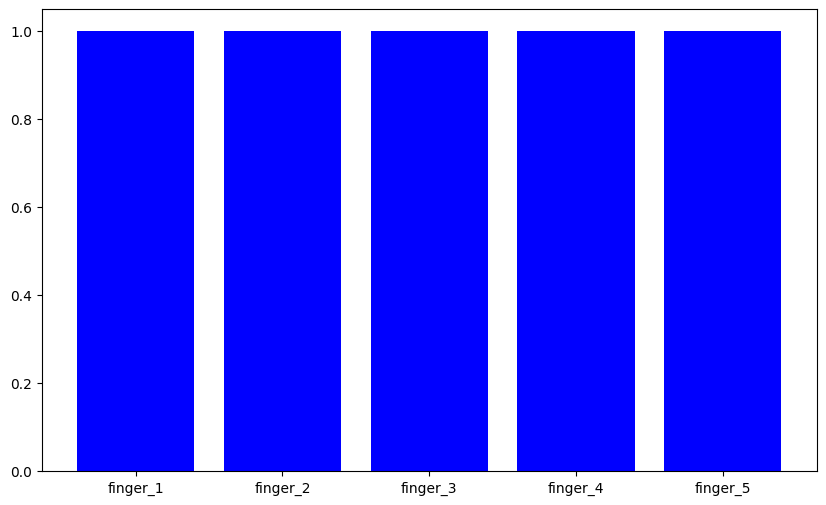

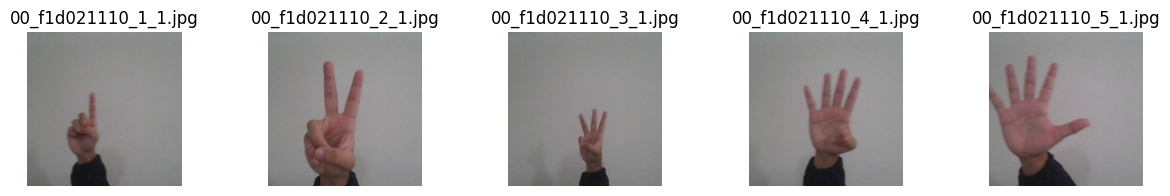

In [405]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = []
    image_counts = {}
    for label in os.listdir(folder):
        datalabel.append(label)
        print(label)
        image_counts[label] = 0
        for filename in os.listdir(os.path.join(folder, label)):
            img = cv.imread(os.path.join(folder, label, filename))
            if img is not None:
                filenames.append(filename) 
                data.append(img)
                image_counts[label] += 1
                break
    plt.figure(figsize=(10, 6))
    plt.bar(image_counts.keys(), image_counts.values(), color='blue')
    plt.show()
    return data, filenames, datalabel

data, filenames, label = insertGambar("../modul-6-jurnal-nabilaazkiya/dataset/")
display(data, filenames, 1, 5)

Data yang digunakan berasal dari folder yang berisi gambar yang dikelompokkan berdasarkan label. Jumlah total data dapat bervariasi tergantung pada jumlah gambar dalam setiap subfolder (label).

Jumlah kelas ditentukan oleh jumlah subfolder dalam folder dataset. Setiap subfolder mewakili satu kelas.

Data gambar diperoleh dari folder dataset yang telah disiapkan sebelumnya. Gambar-gambar tersebut dikelompokkan dalam subfolder berdasarkan label masing-masing.

## Data Preparation

### Data Augmentation

In [406]:
def rotateCw(img, degree):
    rad = -(degree * np.pi) / 180
    height, width = img.shape[:2]
    rotateimg = np.zeros((height, width, 3), dtype=img.dtype)
    x_cent = width // 2
    y_cent = height // 2
    cosa = math.cos(rad)
    sina = math.sin(rad)
    
    for i in range(height):
        for j in range(width):
            x = int(cosa * (j - x_cent) - sina * (i - y_cent) + x_cent)
            y = int(sina * (j - x_cent) + cosa * (i - y_cent) + y_cent)
            if 0 <= x < width and 0 <= y < height:
                rotateimg[i, j] = img[y, x]
            else:
                rotateimg[i, j] = 0
    return rotateimg

In [407]:
def mirrory(img):
    height, width = img.shape[:2]
    result = np.zeros((height, width, 3), dtype=img.dtype)
    for i in range(height):
        for j in range(width):
            result[i][j] = img[i][width - 1 - j]
    return result

def mirrorx(img):
    height, width = img.shape[:2]
    result = np.zeros((height, width, 3), dtype=img.dtype)
    for i in range(height):
        for j in range(width):
            result[i][j] = img[height - 1 - i][j]
    return result

In [408]:
def rotate_all_images(data, degree):
    rotated_img = rotateCw(data, degree)
    return rotated_img

In [409]:
def mirror_all_images(data, direction='horizontal'):
    if direction == 'horizontal':
        mirrored_img = mirrory(data)
    elif direction == 'vertical':
        mirrored_img = mirrorx(data)
    else:
        raise ValueError("Direction must be 'horizontal' or 'vertical'")
    return mirrored_img


In [410]:
def augmentasi(data, filenames, banyakData):
    augmented_data = []
    augmented_filenames = []
    for i in range(len(data)):
        augmented_data.append(data[i])
        augmented_filenames.append(filenames[i])
        for j in range(banyakData):
            if j % 4 == 0:
                augmented_data.append(rotate_all_images(data[i], 90))
                augmented_filenames.append(filenames[i])
            elif j % 4 == 1:
                augmented_data.append(rotate_all_images(data[i], -90))
                augmented_filenames.append(filenames[i])
            elif j % 4 == 2:
                augmented_data.append(mirror_all_images(data[i], 'vertical'))
                augmented_filenames.append(filenames[i])
            elif j % 4 == 3:
                augmented_data.append(mirror_all_images(data[i], 'horizontal'))
                augmented_filenames.append(filenames[i])
    return augmented_data, augmented_filenames

# Panggil fungsi augmentasi dengan argumen yang benar
augmented, augmented_filenames = augmentasi(data, filenames, 4) 

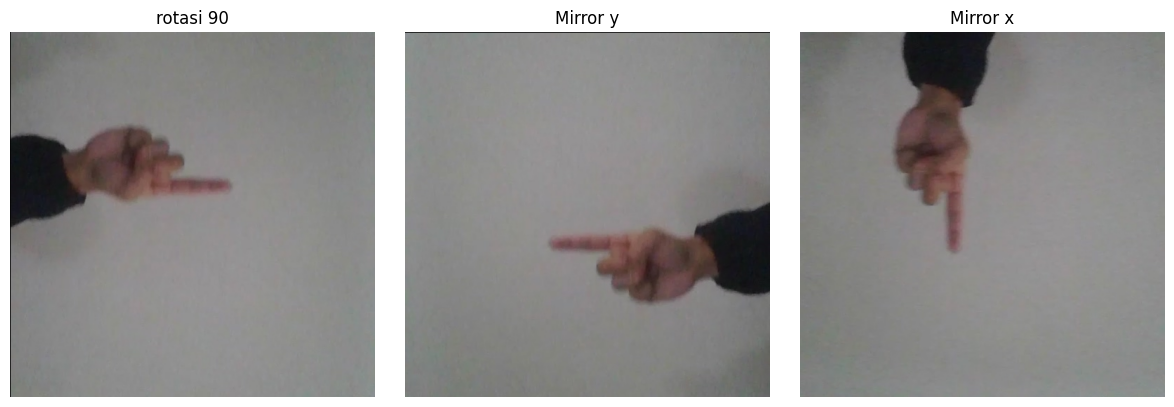

In [411]:
plt.figure(figsize=(12, 4))

# Menampilkan gambar rotasi
plt.subplot(1, 3, 1)
plt.title("rotasi 90")
plt.imshow(cv.cvtColor(augmented[1], cv.COLOR_BGR2RGB))
plt.axis('off')

# Menampilkan gambar cermin vertikal
plt.subplot(1, 3, 2)
plt.title("Mirror y")
plt.imshow(cv.cvtColor(augmented[2], cv.COLOR_BGR2RGB))
plt.axis('off')

# Menampilkan gambar cermin horizontal
plt.subplot(1, 3, 3)
plt.title("Mirror x")
plt.imshow(cv.cvtColor(augmented[3], cv.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

Peoses augmentation menggunakan beberapa teknik augmentasi gambar untuk meningkatkan variasi data. Teknik yang digunakan termasuk rotasi gambar dan pembalikan gambar (mirroring). Secara spesifik, memutar gambar sebesar 90 derajat searah jarum jam dan -90 derajat berlawanan arah jarum jam. Selain itu, kami juga membalik gambar secara vertikal (mirror x) dan horizontal (mirror y).Teknik augmentasi ini membantu dalam memperkaya dataset dan meningkatkan kinerja model pembelajaran mesin dengan menyediakan lebih banyak variasi dalam data latih.

### Preprocessing

#### Preprocessing 1

In [412]:
def grayScale(img):
    height, width, _ = img.shape
    grayedImg = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            redImg = int(img[i, j, 2])  
            greenImg = int(img[i, j, 1])  
            blueImg = int(img[i, j, 0])
            grayValue = (redImg + greenImg + blueImg) // 3
            grayedImg[i, j] = grayValue
    return grayedImg

In [413]:
def apply_gray_scale(hasil):
    gray_results = []
    for img in hasil:
        gray_results.append(grayScale(img))
    return gray_results

gray_hasil = apply_gray_scale(augmented)

25


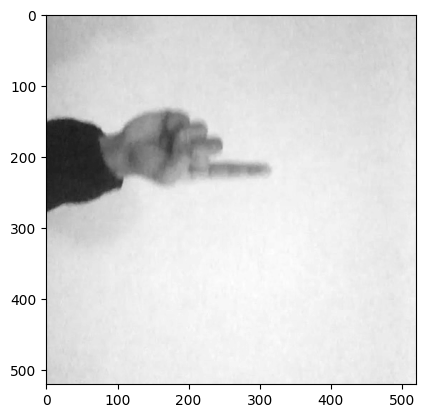

In [414]:
plt.imshow(gray_hasil[1], cmap='gray')
print(len(gray_hasil))

#### Preprocessing 2

In [415]:
def normalize(img):
    minValue = np.min(img)
    maxValue = np.max(img)
    return np.round((img - minValue) / (maxValue - minValue))


In [416]:
def apply_normalize(hasil):
    normalize_results = []
    for img in hasil:
        normalize_data = normalize(img)
        normalize_results.append(normalize_data)
    return normalize_results
normalize_hasil = apply_normalize(gray_hasil)



25


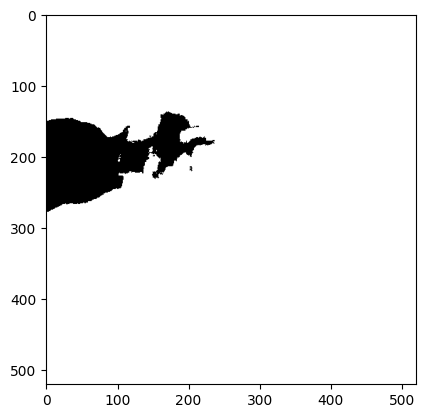

In [417]:
plt.imshow(normalize_hasil[1], cmap='gray')
print(len(normalize_hasil))

#### Preprocessing n

### Feature Extraction

In [418]:
def derajat0(img): 
    max_val = int(np.max(img)) + 1
    imgTmp = np.zeros((max_val, max_val))
    for i in range(len(img)):
        for j in range(len(img[i])-1):
            index_i = int(img[i, j])
            index_j = int(img[i, j+1])
            if index_i < max_val and index_j < max_val:
                imgTmp[index_i, index_j] += 1
    data = imgTmp + np.transpose(imgTmp)
    tmp = np.sum(data)
    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

def derajat45(img):
    max_val = int(np.max(img)) + 1
    imgTmp = np.zeros((max_val, max_val))
    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            index_i = int(img[i+1, j])
            index_j = int(img[i, j+1])
            if index_i < max_val and index_j < max_val:
                imgTmp[index_i, index_j] += 1
    data = imgTmp + np.transpose(imgTmp)
    tmp = np.sum(data)
    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

def derajat90(img):
    max_val = int(np.max(img)) + 1
    imgTmp = np.zeros((max_val, max_val))
    for i in range(len(img)-1):
        for j in range(len(img[i])):
            index_i = int(img[i+1, j])
            index_j = int(img[i, j])
            if index_i < max_val and index_j < max_val:
                imgTmp[index_i, index_j] += 1
    data = imgTmp + np.transpose(imgTmp)
    tmp = np.sum(data)
    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

def derajat135(img):
    max_val = int(np.max(img)) + 1
    imgTmp = np.zeros((max_val, max_val))
    for i in range(len(img)-1):
        for j in range(len(img[i])-1):
            index_i = int(img[i+1, j])
            index_j = int(img[i, j+1])
            if index_i < max_val and index_j < max_val:
                imgTmp[index_i, index_j] += 1
    data = imgTmp + np.transpose(imgTmp)
    tmp = np.sum(data)
    for i in range(len(data)):
        for j in range(len(data)):
            data[i, j] /= tmp
    return data

In [419]:
hasil1 = []
for dat in tqdm(normalize_hasil):
    feature_set = []
    feature_set.append(derajat0(dat))
    feature_set.append(derajat45(dat))
    feature_set.append(derajat90(dat))
    feature_set.append(derajat135(dat))
    hasil1.append(feature_set)

100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


In [420]:
def contrast(data):
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += data[i, j] + pow(i - j, 2)
    return simpan

def dissimilarity(data): 
    simpan = 0
    for i in range(len(data)): 
        for j in range(len(data)):
            simpan += data[i, j] + abs(i - j)
    return simpan

def homogenitas(data): 
    simpan = 0 
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += data[i, j] / (1 + abs(i - j))
    return simpan

def entropi(data): 
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            if data[i, j] > 0:
                simpan += -(data[i, j] * math.log(data[i, j]))
    return simpan

def ASM(data): 
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += pow(data[i, j], 2)
    return simpan 

def energy(data): 
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += pow(data[i, j], 2)
    return simpan

def correlation(data): 
    mI = np.sum(np.arange(data.shape[0])[:, None] * np.sum(data, axis=1)) / np.sum(data)
    mJ = np.sum(np.arange(data.shape[1])[None, :] * np.sum(data, axis=0)) / np.sum(data)
    
    tI = np.sqrt(np.sum(((np.arange(data.shape[0])[:, None] - mI) ** 2) * np.sum(data, axis=1)) / np.sum(data))
    tJ = np.sqrt(np.sum(((np.arange(data.shape[1])[None, :] - mJ) ** 2) * np.sum(data, axis=0)) / np.sum(data))
    
    simpan = 0
    for i in range(len(data)):
        for j in range(len(data)):
            simpan += ((i - mI) * (j - mJ) * data[i, j]) / (tI * tJ)
    return simpan

In [421]:
path = np.zeros(len(augmented_filenames), dtype = object)
for i in range(len(augmented_filenames)):
    for j in range(len(augmented_filenames[i])):
        if augmented_filenames[i][j] == '.':
            break
        if augmented_filenames[i][j+1] == '_' and augmented_filenames[i][j-1] == '_':
            labels = "Finger_"+augmented_filenames[i][j]
    path[i] = labels

In [422]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
result = []

for i in tqdm(range(len(hasil1))):
    extracted_data = []
    extracted_data.append(path[i])
    for j in range(len(hasil1[i])):
        contrast_val = contrast(hasil1[i][j])
        extracted_data.append(contrast_val)
    for j in range(len(hasil1[i])):
        dissimilarity_val = dissimilarity(hasil1[i][j])
        extracted_data.append(dissimilarity_val)
    for j in range(len(hasil1[i])):
        homogeneity_val = homogenitas(hasil1[i][j])
        extracted_data.append(homogeneity_val)
    for j in range(len(hasil1[i])):
        energy_val = energy(hasil1[i][j])
        extracted_data.append(energy_val)
    for j in range(len(hasil1[i])):
        correlation_val = correlation(hasil1[i][j])
        extracted_data.append(correlation_val)
    for j in range(len(hasil1[i])):
        asm_val = ASM(hasil1[i][j])
        extracted_data.append(asm_val)
        entropy_val = entropi(hasil1[i][j])
        extracted_data.append(entropy_val)
    result.append(extracted_data)

100%|██████████| 25/25 [00:00<00:00, 1625.98it/s]


In [423]:
headers = ['Path']
for fitur in fiturs:
    headers.extend([f'{fitur}_0', f'{fitur}_45', f'{fitur}_90', f'{fitur}_135'])
for angle in angles:
    headers.extend([f'asm_{angle}', f'entropy_{angle}'])
df = pd.DataFrame(result, columns=headers)
df.to_csv('extracted_data.csv', index=False)
df.head(2)

,Path,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,...,correlation_90,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135
0,Finger_1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.998573,...,0.247769,0.24484,0.869724,0.267067,0.869037,0.271193,0.870848,0.262647,0.869037,0.271193
1,Finger_1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.998229,...,0.237643,0.23227,0.880259,0.253199,0.879262,0.257343,0.879618,0.250525,0.879262,0.257343


### Features Selection

In [424]:
from sklearn.feature_selection import VarianceThreshold
df = pd.read_csv('extracted_data.csv')
x = df.drop('Path', axis=1)
y = df['Path']
selector = VarianceThreshold()
x = selector.fit_transform(x)

### Splitting Data

### Normalization

## Modeling

## Evaluation